In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ..

/home/pierre/git/bo-on-graph


In [4]:
import os
import torch
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
matplotlib.rcParams.update({'font.size': 22})
supported_labels = [
    "random",
    "local_search",
    "ei",
    "ei_ego_network_1",
    "ei_ego_network_1_old",
    "dfs",
    "bfs",
    "ei_ego_network_2",
    "ei_ego_network_2_no_ard",
]
# cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']))
d_color = {"ei_ego_network_1":"#1f77b4", "ei_ego_network_2":"#8c564b", "random":"#ff7f0e",
           "local_search":"#2ca02c", "dfs": "#d62728", "bfs": "#9467bd", "ei_ego_network_1_old":"#e377c2",
           "ei_ego_network_2_no_ard":"#7f7f7f"}
d_label = {"ei_ego_network_1":"BO_Poly", "ei_ego_network_1_old":"BO_SumInverse",
           "ei_ego_network_2":"BO_Diff_ARD", "ei_ego_network_2_no_ard":"BO_Diff", 
           "random":"Random", "local_search":"Local search", "dfs": "Dfs", "bfs": "Bfs"}



/home/pierre/miniconda3/envs/graph/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def plot_result(ax, path: str, label: str, plot_kwargs: dict = None, median=False, std=False, cumulative=True, regret=True):
    # path: main directory of experiments (eg. logs/centrality), label : label experiment to plot
    exp_dir = os.path.join(path, label)
    algorithm_name = [name for name in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, name))]
    min_max_len = np.inf
    for algorithm in algorithm_name:
        alg_dir = os.path.join(exp_dir, algorithm)
        ## Here are in directory with signal png and pt
        plot_kwargs = deepcopy(plot_kwargs) or {}
        data_path_seeds = [f for f in os.listdir(alg_dir) if ".pt" in f]
        data_over_seeds = []
        for i, df in enumerate(data_path_seeds):
            data_path = os.path.join(alg_dir, df)
            with open(data_path, "rb") as fp:
                data = torch.load(data_path, map_location="cpu")
                minimize = False
            if "regret" in data.keys() and regret:
                y = -data["regret"].numpy().flatten()   # to maximize negative regret
                minimize = True
            else:
                assert "Y" in data.keys()
                y = data["Y"].numpy().flatten()
            data_over_seeds.append(y)
        n_data_per_trial = np.array([len(d) for d in data_over_seeds])
        max_len = max(n_data_per_trial)
        if len(np.unique(n_data_per_trial)) > 1:
            # pad as appropriate
            for i, d in enumerate(data_over_seeds):
                data_over_seeds[i] = np.concatenate((
                    d, d[-1] * np.ones(max_len - d.shape[0])))
        all_data = np.array(data_over_seeds)
        if cumulative:
            y = pd.DataFrame(all_data).cummax(axis=1)
        else:
            y = pd.DataFrame(all_data)
        x = np.arange(all_data.shape[1])
        if median:
            mean = y.median(axis=0)
            lb = y.quantile(q=0.25, axis=0)
            ub = y.quantile(q=0.75, axis=0)
        elif std:
            mean = y.mean(axis=0)
            # standard error
            lb = mean - y.std(axis=0)
            ub = mean + y.std(axis=0)
        else:
            mean = y.mean(axis=0)
            # standard error
            lb = mean - y.std(axis=0) / np.sqrt(all_data.shape[0])
            ub = mean + y.std(axis=0) / np.sqrt(all_data.shape[0])
        if minimize:
            mean = -mean
            lb = -lb
            ub = -ub
        ax.plot(x, mean, ".-", label=d_label[algorithm], color=d_color[algorithm], **plot_kwargs)
        if "alpha" in plot_kwargs.keys():
            del plot_kwargs["alpha"]
        if "markevery" in plot_kwargs.keys():
            del plot_kwargs["markevery"]
        ax.fill_between(x, lb, ub, alpha=0.1, color=d_color[algorithm], **plot_kwargs)
        min_max_len = min(min_max_len, max_len)
    #ax.legend()
    ax.set_xlabel("\#Iters")
    ax.set_ylabel("Objective")
    ax.set_xlim([0, min_max_len])
    ax.grid()
    #plt.yscale("log")
    
    #plt.savefig(os.path.join(exp_dir, "plot_result_regretpng.png"), bbox_inches='tight')
    #plt.savefig(os.path.join(exp_dir, "plot_result_regretpdf.pdf"), bbox_inches='tight')
    #plt.clf()
    #return y, max_len

0 0
0 1
0 2
1 0
1 1
1 2


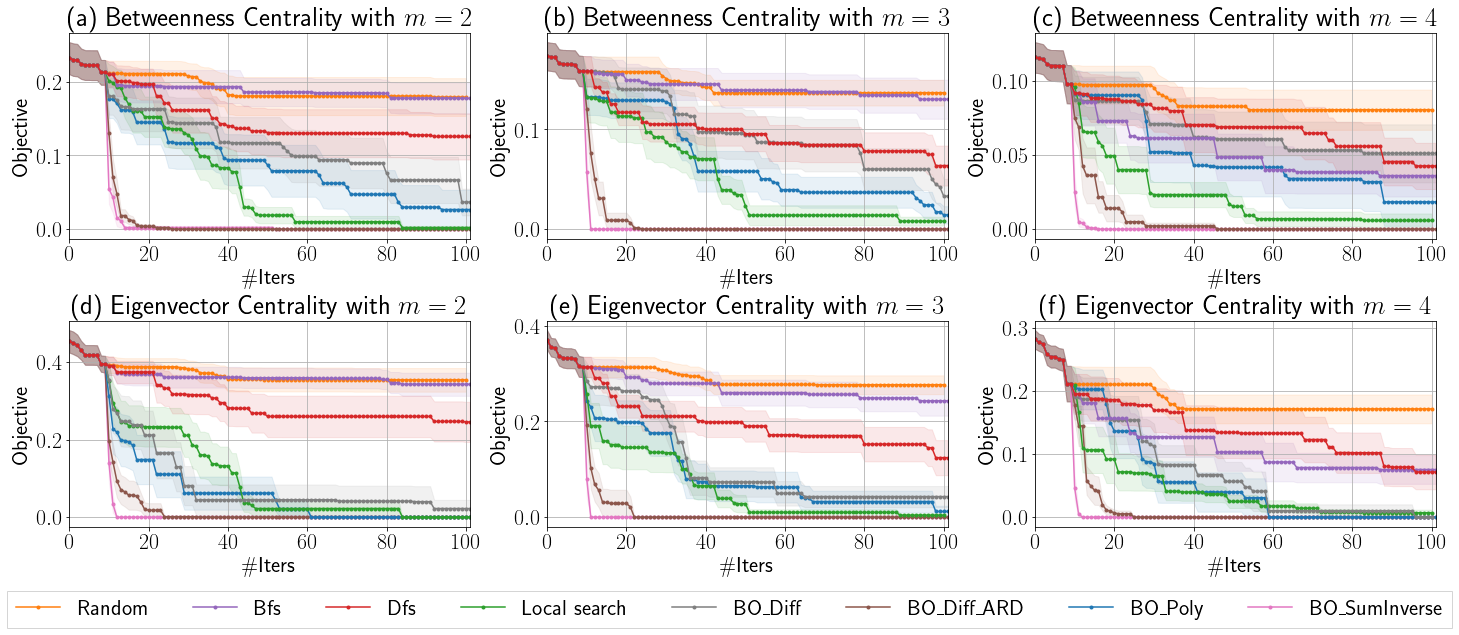

In [52]:
list_experiences = ["ba_betweenness_m-2_ninit-20_n-1000", "ba_betweenness_m-3_ninit-20_n-1000", "ba_betweenness_m-4_ninit-20_n-1000",
                    "ba_eigenvector_centrality_m-2_ninit-20_n-1000", "ba_eigenvector_centrality_m-3_ninit-20_n-1000", "ba_eigenvector_centrality_m-4_ninit-20_n-1000"]
n_rows, n_cols = 2, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/centrality/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Betweenness Centrality with ' + r'$m = 2$')
axs[0, 1].title.set_text('(b) Betweenness Centrality with ' + r'$m = 3$')
axs[0, 2].title.set_text('(c) Betweenness Centrality with ' + r'$m = 4$')
axs[1, 0].title.set_text('(d) Eigenvector Centrality with ' + r'$m = 2$')
axs[1, 1].title.set_text('(e) Eigenvector Centrality with ' + r'$m = 3$')
axs[1, 2].title.set_text('(f) Eigenvector Centrality with ' + r'$m = 4$')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("centrality_ba.pdf", bbox_inches='tight')

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3


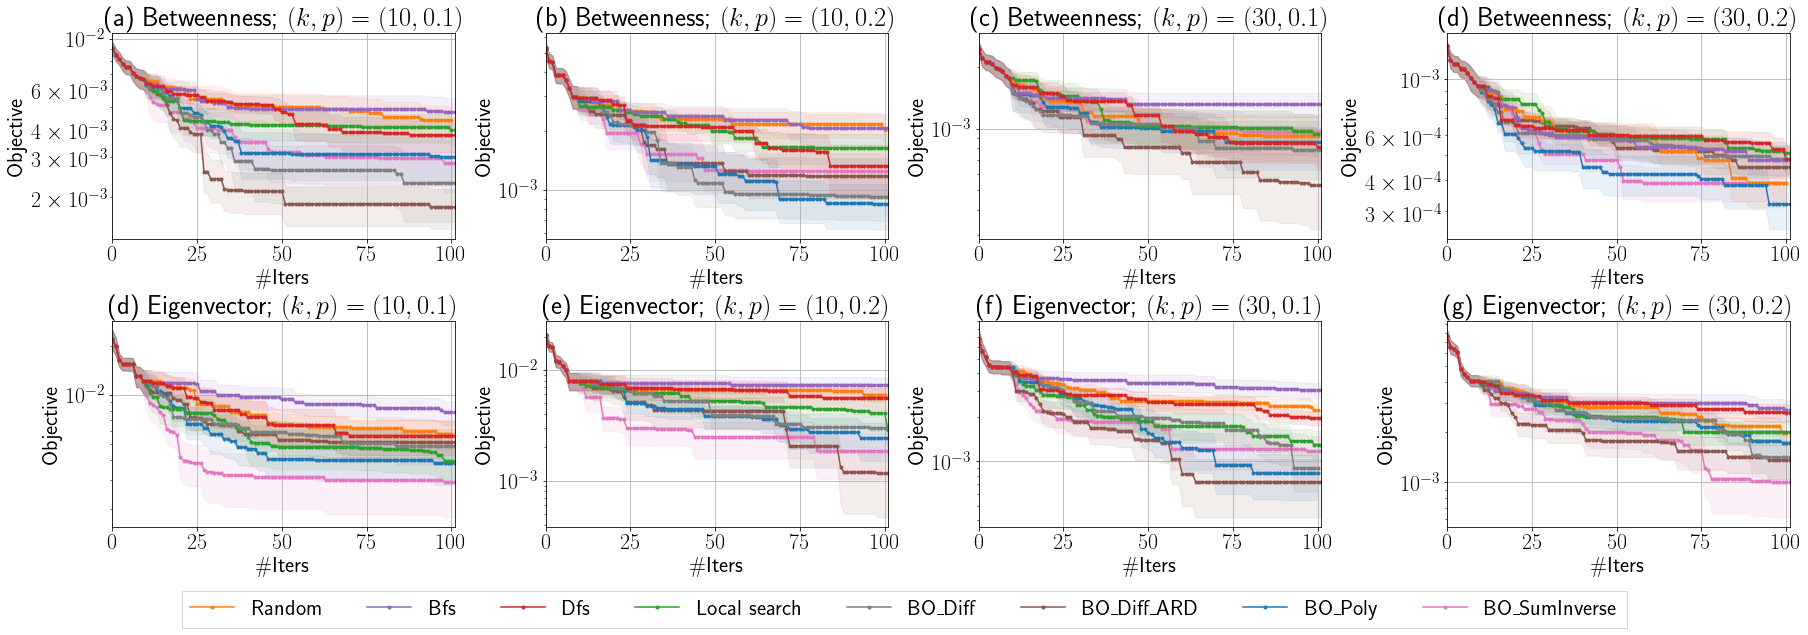

In [57]:
list_experiences = ["ws_betweenness_k-10_p-0.1_ninit-20_n-2000", "ws_betweenness_k-10_p-0.2_ninit-20_n-2000", "ws_betweenness_k-30_p-0.1_ninit-20_n-2000", "ws_betweenness_k-30_p-0.2_ninit-20_n-2000",
                    "ws_eigenvector_centrality_k-10_p-0.1_ninit-20_n-2000", "ws_eigenvector_centrality_k-10_p-0.2_ninit-20_n-2000", "ws_eigenvector_centrality_k-30_p-0.1_ninit-20_n-2000", "ws_eigenvector_centrality_k-30_p-0.2_ninit-20_n-2000"]
n_rows, n_cols = 2, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(25, 8))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/centrality/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Betweenness; ' + r'$(k, p)=(10, 0.1)$')
axs[0, 0].set_yscale("log")
axs[0, 1].title.set_text('(b) Betweenness; ' + r'$(k, p)=(10, 0.2)$')
axs[0, 1].set_yscale("log")
axs[0, 2].title.set_text('(c) Betweenness; ' + r'$(k, p)=(30, 0.1)$')
axs[0, 2].set_yscale("log")
axs[0, 3].title.set_text('(d) Betweenness; ' + r'$(k, p)=(30, 0.2)$')
axs[0, 3].set_yscale("log")
axs[1, 0].title.set_text('(d) Eigenvector; ' + r'$(k, p)=(10, 0.1)$')
axs[1, 0].set_yscale("log")
axs[1, 1].title.set_text('(e) Eigenvector; ' + r'$(k, p)=(10, 0.2)$')
axs[1, 1].set_yscale("log")
axs[1, 2].title.set_text('(f) Eigenvector; ' + r'$(k, p)=(30, 0.1)$')
axs[1, 2].set_yscale("log")
axs[1, 3].title.set_text('(g) Eigenvector; ' + r'$(k, p)=(30, 0.2)$')
axs[1, 3].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("centrality_ws.pdf", bbox_inches='tight')

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


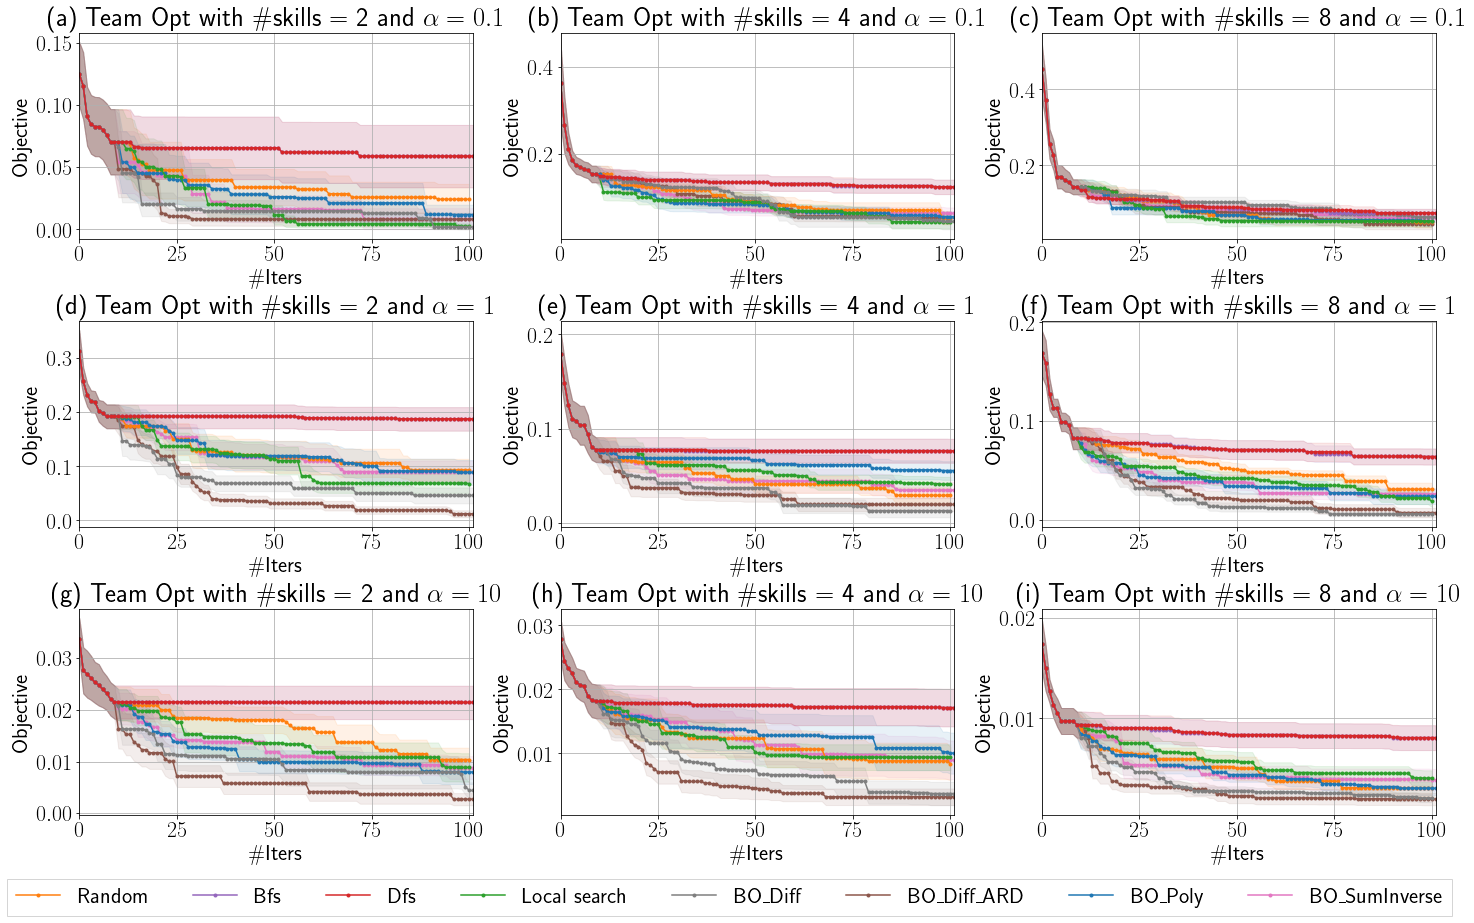

In [49]:
plt.rcParams['text.usetex'] = True
list_experiences = ["jaccard_n_skills-2_alpha-0.1_n_individuals-10_threshold-0.2", "jaccard_n_skills-2_alpha-1_n_individuals-10_threshold-0.2", "jaccard_n_skills-2_alpha-10_n_individuals-10_threshold-0.2",
                    "jaccard_n_skills-4_alpha-0.1_n_individuals-10_threshold-0.2", "jaccard_n_skills-4_alpha-1_n_individuals-10_threshold-0.2", "jaccard_n_skills-4_alpha-10_n_individuals-10_threshold-0.2",
                    "jaccard_n_skills-8_alpha-0.1_n_individuals-10_threshold-0.2", "jaccard_n_skills-8_alpha-1_n_individuals-10_threshold-0.2", "jaccard_n_skills-8_alpha-10_n_individuals-10_threshold-0.2"]
n_rows, n_cols = 3, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 12))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_col, idx_row], "./logs/teams/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 0.1$')
axs[0, 1].title.set_text('(b) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 0.1$')
axs[0, 2].title.set_text('(c) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 0.1$')
axs[1, 0].title.set_text('(d) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 1$')
axs[1, 1].title.set_text('(e) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 1$')
axs[1, 2].title.set_text('(f) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 1$')
axs[2, 0].title.set_text('(g) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 10$')
axs[2, 1].title.set_text('(h) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 10$')
axs[2, 2].title.set_text('(i) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 10$')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("teamopt_02.pdf", bbox_inches='tight')

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


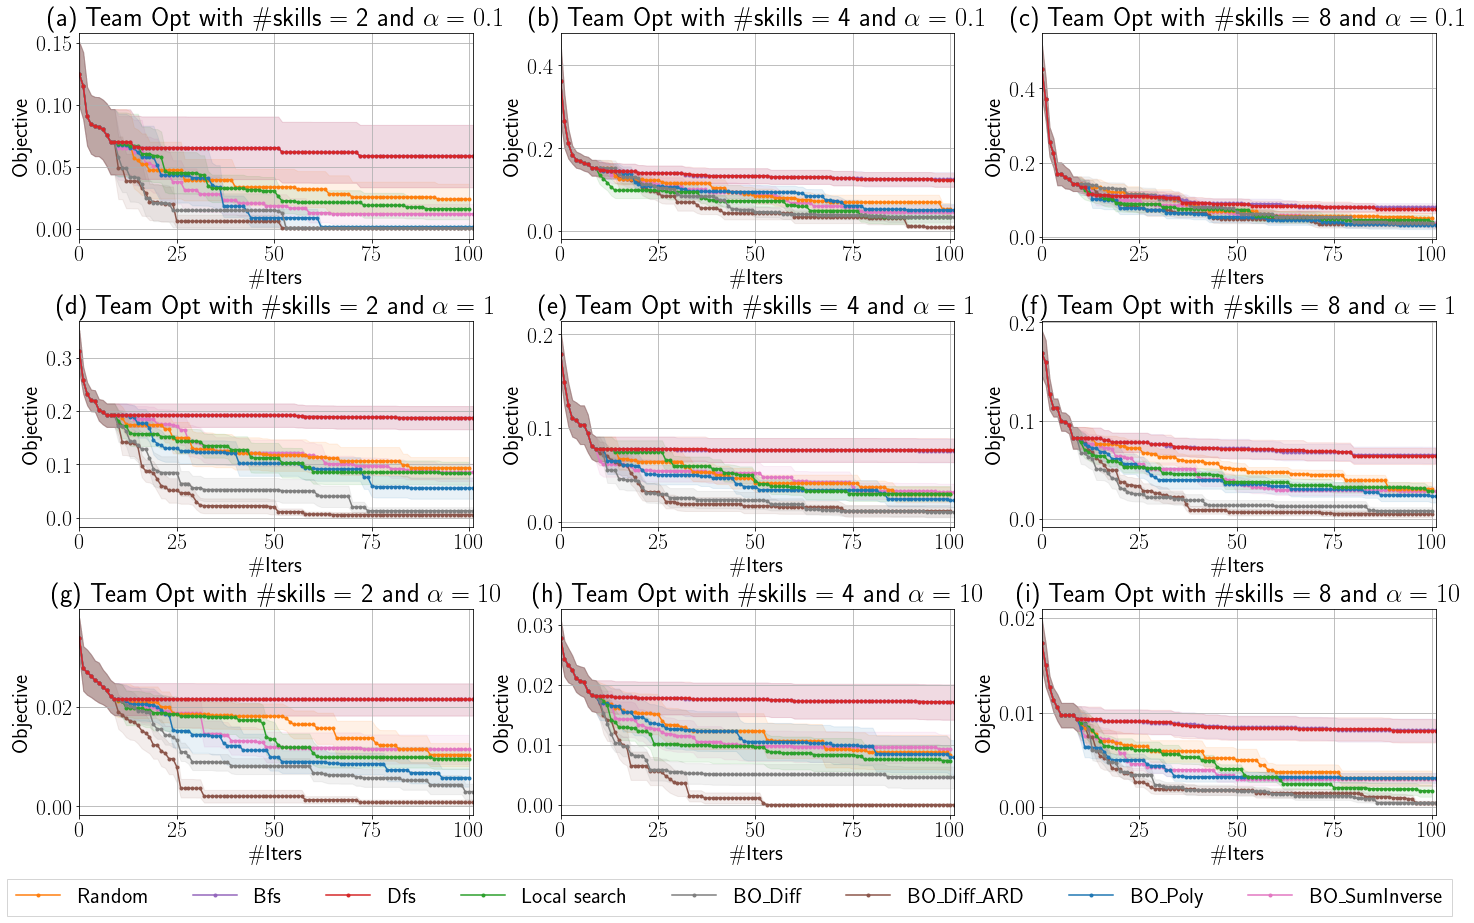

In [50]:
plt.rcParams['text.usetex'] = True
list_experiences = ["jaccard_n_skills-2_alpha-0.1_n_individuals-10_threshold-0.3", "jaccard_n_skills-2_alpha-1_n_individuals-10_threshold-0.3", "jaccard_n_skills-2_alpha-10_n_individuals-10_threshold-0.3",
                    "jaccard_n_skills-4_alpha-0.1_n_individuals-10_threshold-0.3", "jaccard_n_skills-4_alpha-1_n_individuals-10_threshold-0.3", "jaccard_n_skills-4_alpha-10_n_individuals-10_threshold-0.3",
                    "jaccard_n_skills-8_alpha-0.1_n_individuals-10_threshold-0.3", "jaccard_n_skills-8_alpha-1_n_individuals-10_threshold-0.3", "jaccard_n_skills-8_alpha-10_n_individuals-10_threshold-0.3"]
n_rows, n_cols = 3, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 12))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_col, idx_row], "./logs/teams/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 0.1$')
axs[0, 1].title.set_text('(b) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 0.1$')
axs[0, 2].title.set_text('(c) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 0.1$')
axs[1, 0].title.set_text('(d) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 1$')
axs[1, 1].title.set_text('(e) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 1$')
axs[1, 2].title.set_text('(f) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 1$')
axs[2, 0].title.set_text('(g) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 10$')
axs[2, 1].title.set_text('(h) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 10$')
axs[2, 2].title.set_text('(i) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 10$')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("teamopt_03.pdf", bbox_inches='tight')

0 0
0 1
0 2
1 0
1 1
1 2


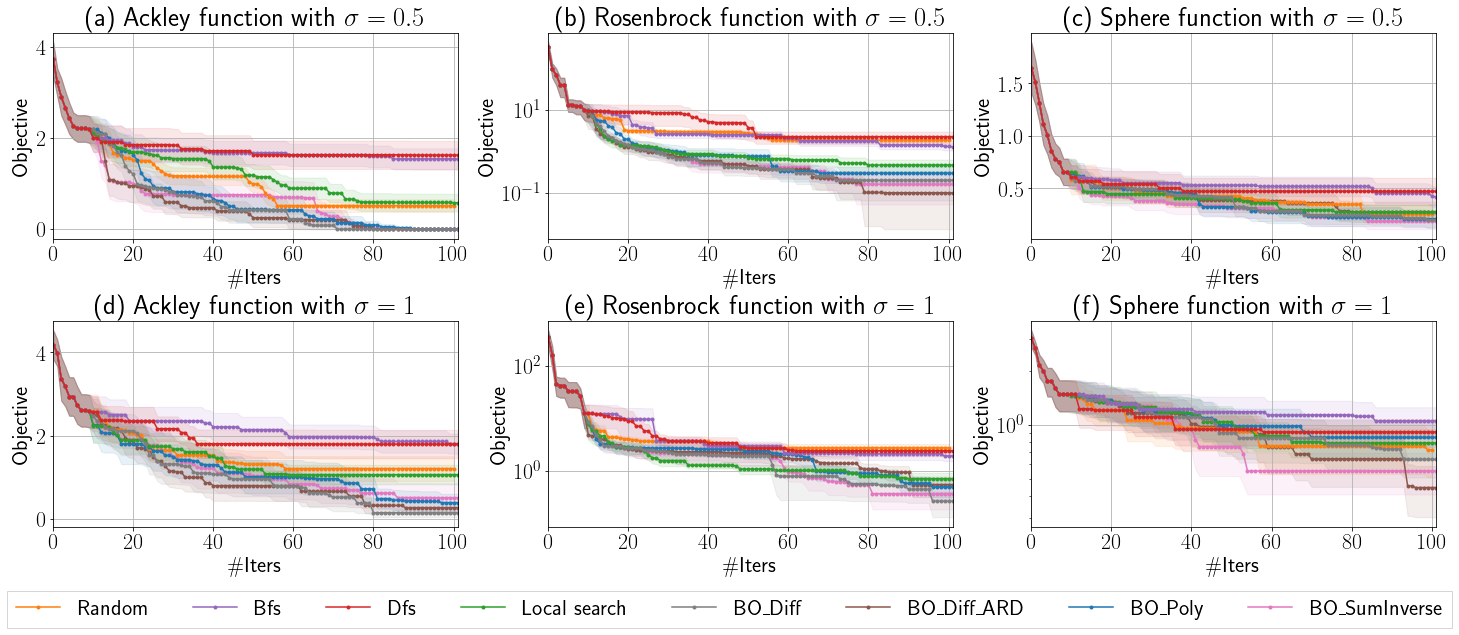

In [59]:
plt.rcParams['text.usetex'] = True
list_experiences = ["ackley_noise-0.5_n-1000", "rosenbrock_noise-0.5_n-1000", "sphere_noise-0.5_n-1000",
                    "ackley_noise-1.0_n-1000", "rosenbrock_noise-1.0_n-1000", "sphere_noise-1.0_n-1000"]
n_rows, n_cols = 2, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/testfunction/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Ackley function with ' + r'$\sigma = 0.5$')
axs[0, 1].title.set_text('(b) Rosenbrock function with ' + r'$\sigma = 0.5$')
axs[0, 1].set_yscale("log")
axs[0, 2].title.set_text('(c) Sphere function with ' + r'$\sigma = 0.5$')
axs[1, 2].set_yscale("log")
axs[1, 0].title.set_text('(d) Ackley function with ' + r'$\sigma = 1$')
axs[1, 1].title.set_text('(e) Rosenbrock function with ' + r'$\sigma = 1$')
axs[1, 1].set_yscale("log")
axs[1, 2].title.set_text('(f) Sphere function with ' + r'$\sigma = 1$')
axs[1, 2].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("test_function.pdf", bbox_inches='tight')

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


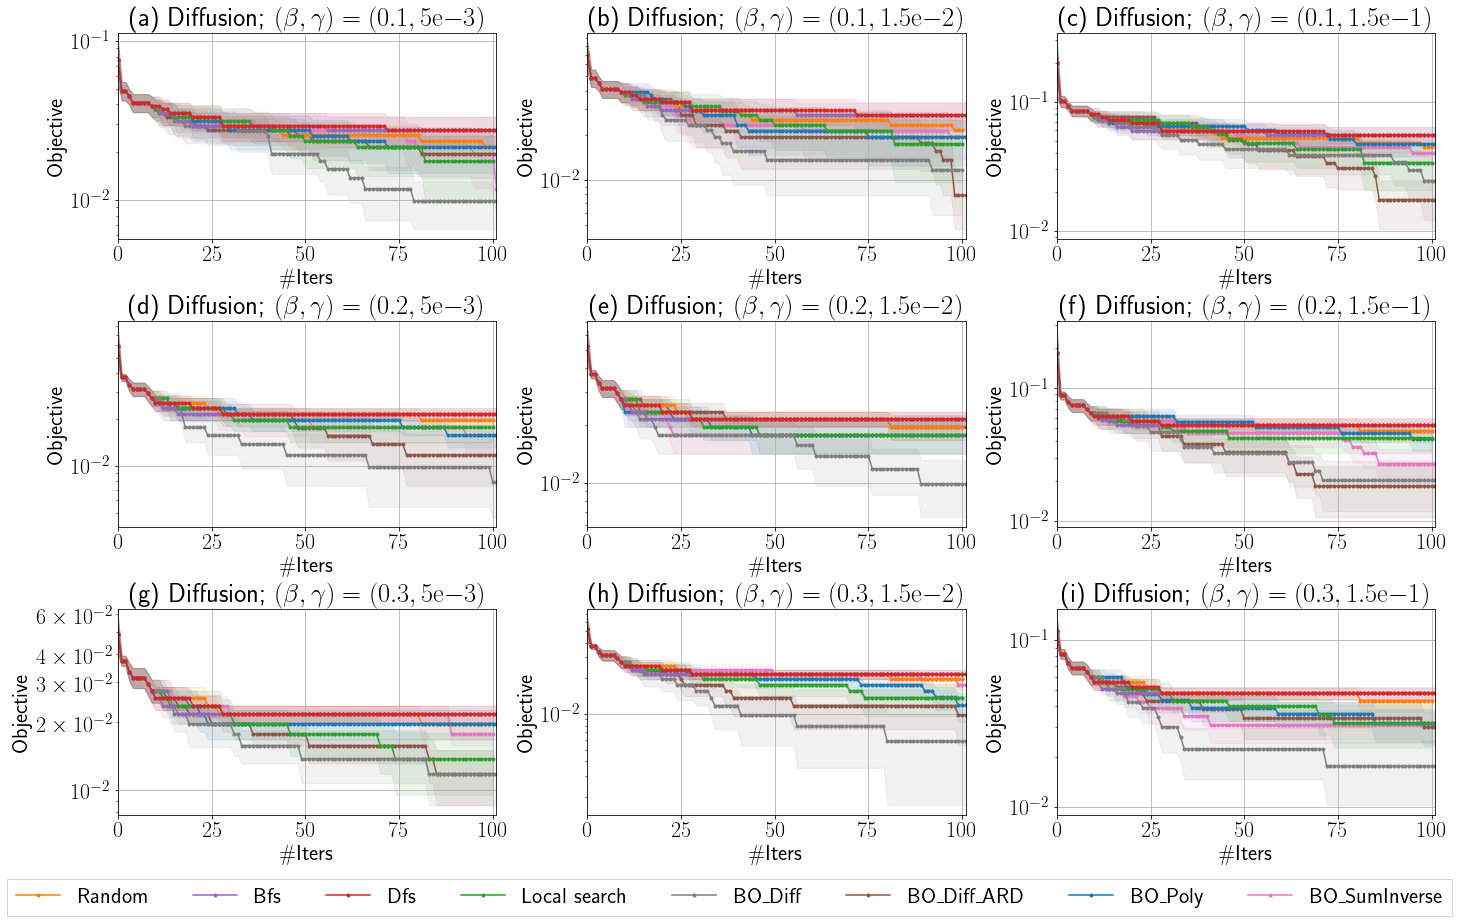

In [10]:
plt.rcParams['text.usetex'] = True
list_experiences = ["beta-0.1_gamma-0.005_fracinfect-3e-4", "beta-0.1_gamma-0.015_fracinfect-3e-4", "beta-0.1_gamma-0.15_fracinfect-3e-4",
                    "beta-0.2_gamma-0.005_fracinfect-3e-4", "beta-0.2_gamma-0.015_fracinfect-3e-4", "beta-0.2_gamma-0.15_fracinfect-3e-4",
                    "beta-0.3_gamma-0.005_fracinfect-3e-4", "beta-0.3_gamma-0.015_fracinfect-3e-4", "beta-0.3_gamma-0.15_fracinfect-3e-4"]
n_rows, n_cols = 3, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 12))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/diffusion_real/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Diffusion; ' + r'$(\beta, \gamma) = (0.1, 5\mathrm{e}{-3})$')
axs[0, 0].set_yscale("log")
axs[0, 1].title.set_text('(b) Diffusion; ' + r'$(\beta, \gamma) = (0.1, 1.5\mathrm{e}{-2})$')
axs[0, 1].set_yscale("log")
axs[0, 2].title.set_text('(c) Diffusion; ' + r'$(\beta, \gamma) = (0.1, 1.5\mathrm{e}{-1})$')
axs[0, 2].set_yscale("log")
axs[1, 0].title.set_text('(d) Diffusion; ' + r'$(\beta, \gamma) = (0.2, 5\mathrm{e}{-3})$')
axs[1, 0].set_yscale("log")
axs[1, 1].title.set_text('(e) Diffusion; ' + r'$(\beta, \gamma) = (0.2, 1.5\mathrm{e}{-2})$')
axs[1, 1].set_yscale("log")
axs[1, 2].title.set_text('(f) Diffusion; ' + r'$(\beta, \gamma) = (0.2, 1.5\mathrm{e}{-1})$')
axs[1, 2].set_yscale("log")
axs[2, 0].title.set_text('(g) Diffusion; ' + r'$(\beta, \gamma) = (0.3, 5\mathrm{e}{-3})$')
axs[2, 0].set_yscale("log")
axs[2, 1].title.set_text('(h) Diffusion; ' + r'$(\beta, \gamma) = (0.3, 1.5\mathrm{e}{-2})$')
axs[2, 1].set_yscale("log")
axs[2, 2].title.set_text('(i) Diffusion; ' + r'$(\beta, \gamma) = (0.3, 1.5\mathrm{e}{-1})$')
axs[2, 2].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("diffusion_real.pdf", bbox_inches='tight')

0 0
0 1
0 2


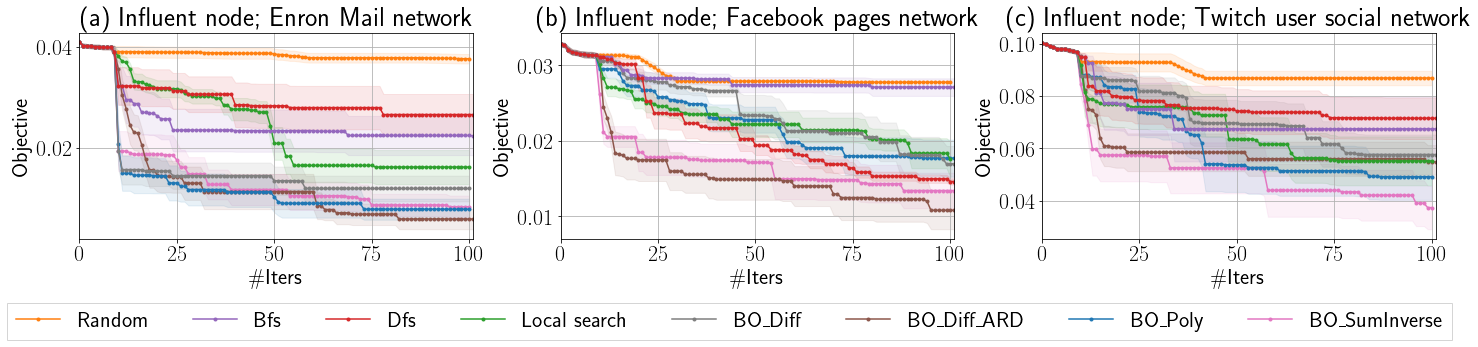

In [14]:
plt.rcParams['text.usetex'] = True
list_experiences = ["real_enron_degree_centrality_contextnodes-100_n_init-20", "real_fb_degree_centrality_contextnodes-100_n_init-20", "real_twitch_degree_centrality_contextnodes-100_n_init-20"]
n_rows, n_cols = 1, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 4))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_col], "./logs/centrality/", list_experiences[i], std=False)

handles, labels = axs[idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0].title.set_text('(a) Influent node; Enron Mail network')
#axs[0, 0].set_yscale("log")
axs[1].title.set_text('(b) Influent node; Facebook pages network')
#axs[0, 1].set_yscale("log")
axs[2].title.set_text('(c) Influent node; Twitch user social network')
#axs[0, 2].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("centrality_real.pdf", bbox_inches='tight')